In [1]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import ROOT as r
import rootnotes
import numpy as np
import matplotlib.pyplot as plt
from rootpy.io import root_open
import rootpy.plotting.root2matplotlib as rplt
from scipy.stats import norm

canvas = rootnotes.default_canvas()

colors = ['#348ABD', '#A60628']

# Use the Bayesian Methods for Hackers style
plt.style.use('bmh')

In [2]:
# Path to the ROOT file that will be used to obtain the toy invariant mass distributions used to evaluate the fitter
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass3/1pt05_mc/tridents/all/invariant_mass_toys_pt167mev.root"

root_file = root_open(file_path)

histos = list(root_file.objects(r.TH1))

## Trident Invariant Mass

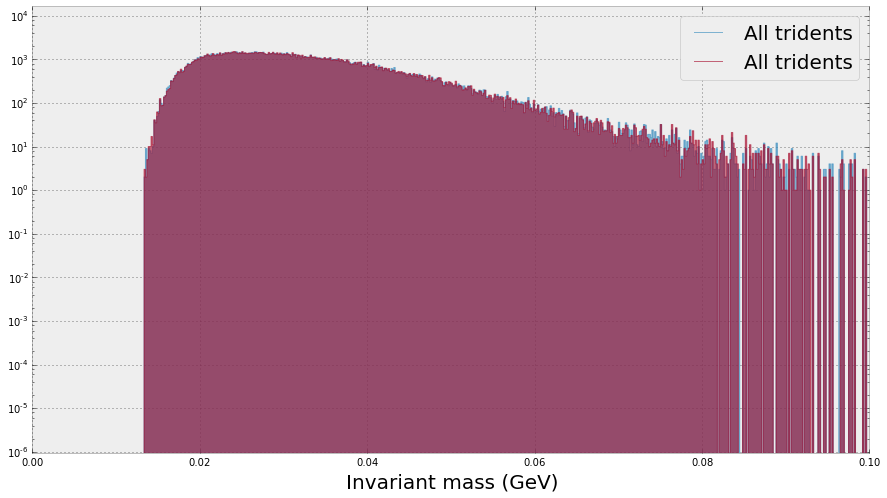

In [3]:
labels = ['All tridents', 'All tridents']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.set_xlabel("Invariant mass (GeV)", fontsize=20)
ax.set_yscale('log')

for histo_n in range(0, 2) : 
    histos[histo_n].linecolor = colors[histo_n]
    histos[histo_n].fillstyle = 'solid'
    histos[histo_n].fillcolor = colors[histo_n]
    rplt.hist(histos[histo_n], axes=ax, alpha=.6, label=labels[histo_n])
    
ax.legend(fontsize=20);

# Composite Model

The trident invariant mass distribution will be searched for a resonance by doing a maximum likelihood fit using the following composite model

$M(x) = N_{S}S(x) + N_BB(x)$

Here, $S(x)$ is a gaussian pdf with a mass set to the hypothesized $A'$ mass and the width set to the measured mass resolution.  The background, $B(x)$ will be described using a, to be determined, polynomial.


In [5]:
invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.005, 0.1)

#
# Signal PDF
#

# The mean of the signal must be set and can't vary
ap_mass_mean = r.RooRealVar("ap_mass_mean", "ap_mass_mean", .04)
ap_mass_mean.setConstant(r.kTRUE)

# The resolution of the signal is set to the value found experimentally
ap_mass_sigma = r.RooRealVar("ap_mass_sigma", "ap_mass_sigma", 0.00167)
ap_mass_sigma.setConstant(r.kTRUE)

# Create a gaussian signal pdf with the mean at the mass hypothesis and sigma
# set to the mass resolution
signal = r.RooGaussian("signal", "signal", invariant_mass, ap_mass_mean, ap_mass_sigma)

#
# Background PDF's
#

# Variables used to define polynomials
a = []

a.append(r.RooRealVar("t1", "t1", 0, -1, 1))
a.append(r.RooRealVar("t2", "t2", 0, -1, 1))
a.append(r.RooRealVar("t3", "t3", 0, -1, 1))
a.append(r.RooRealVar("t4", "t4", 0, -1, 1))
a.append(r.RooRealVar("t5", "t5", 0, -1, 1))
a.append(r.RooRealVar("t6", "t6", 0, -1, 1))
a.append(r.RooRealVar("t7", "t7", 0, -1, 1))

bkg_models = []
arg_list = r.RooArgList()
for var_index in range(0, len(a)) :
    arg_list.add(a[var_index])
    bkg_models.append(r.RooChebychev("bkg_" + str(var_index), 
                                     "bkg_" + str(var_index), 
                                     invariant_mass, 
                                     arg_list)) 
    
# Number of events
nsig = r.RooRealVar("nsig","signal fraction", 0, -3000, 3000)
nbkg = r.RooRealVar("nbkg","background fraction", 80000., 10000., 100000.) 

#
# Composite model
#

comp_models = []
bkg_comp_models = []

for var_index in range(0, len(a)) :   
    comp_models.append(r.RooAddPdf("model_" + str(var_index), 
                              "model_" + str(var_index), 
                               r.RooArgList(signal, bkg_models[var_index]), 
                               r.RooArgList(nsig, nbkg)))
            
    bkg_comp_models.append(r.RooAddPdf("model_" + str(var_index), 
                              "model_" + str(var_index), 
                               r.RooArgList(bkg_models[var_index]), 
                               r.RooArgList(nbkg)))  

# Fitting multiple polynomials within a window

## Background only Fit

Total events: 600.0
chi2/dof: 4.51310331533
chi2/dof: 3.59655492744
chi2/dof: 3.32670027188
chi2/dof: 3.32425569753
chi2/dof: 3.22471839337
chi2/dof: 3.22682530863
chi2/dof: 3.2248527286


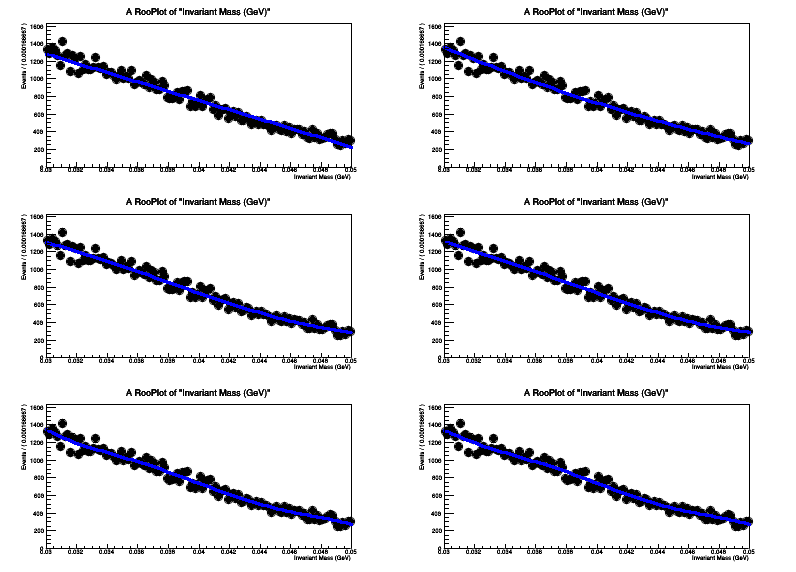

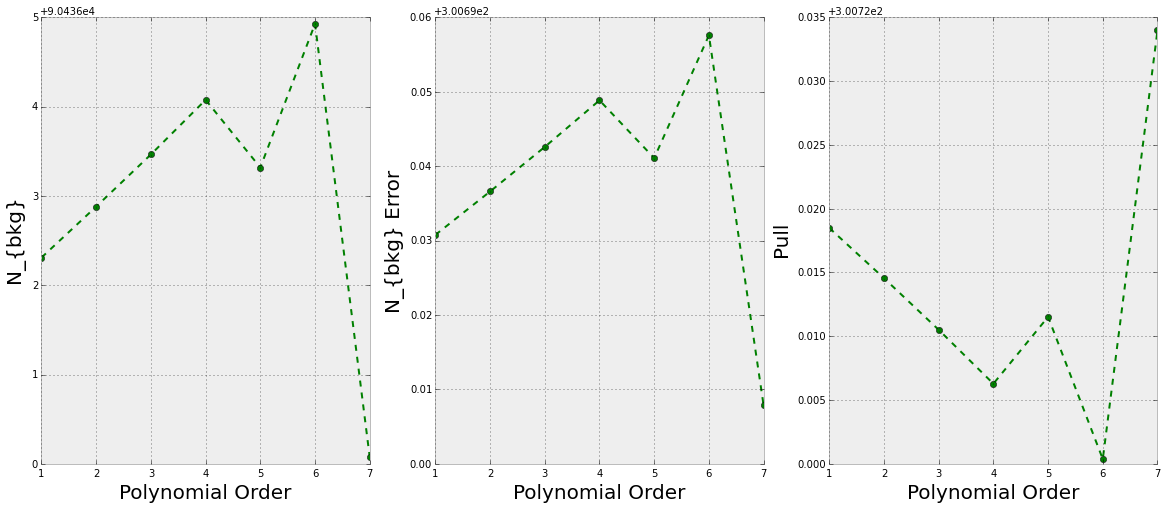

In [57]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

print "Total events: " + str(mass_histo.GetEntries())

# Create a data histogram that is compatible with RooFit
min_val = 0.03
max_val = 0.05
invariant_mass.setRange("test_range", min_val, max_val)
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

canvas.Clear()
canvas.Divide(2,3)

index = 1
    
n_bkg = []
n_bkg_error = []
poly_values = []    

for model in bkg_comp_models : 
    
    # Plot the results
    invariant_mass.setRange(min_val, max_val)
    plot = invariant_mass.frame(r.RooFit.Range("test_range"))
    
    nll = model.createNLL(histogram_data, 
                          r.RooFit.Extended(r.kTRUE), 
                          r.RooFit.Range("test_range"),
                          r.RooFit.SumCoefRange("test_range"))
    
    m = r.RooMinuit(nll)
    
    m.migrad()
    
    result = m.save()
    
    histogram_data.plotOn(plot)
    model.plotOn(plot,
                 r.RooFit.Range("test_range"), 
                 r.RooFit.NormRange("test_range"))
    
    canvas.cd(index)
    plot.Draw()
    
    # Calculate the chi^2
    print "chi2/dof: " + str(plot.chiSquare())
    
    params = model.getVariables()
    n_bkg.append(params.find("nbkg").getVal())
    n_bkg_error.append(params.find("nbkg").getError())
    poly_values.append(index)
    
    
    index += 1

    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

pull = np.divide(np.array(n_bkg), np.array(n_bkg_error))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 8))

ax0.plot(poly_values, n_bkg, 'g--o')
ax0.set_xlabel("Polynomial Order", fontsize=20)
ax0.set_ylabel("N_{bkg}", fontsize=20)
ax1.plot(poly_values, n_bkg_error, 'g--o')
ax1.set_xlabel("Polynomial Order", fontsize=20)
ax1.set_ylabel("N_{bkg} Error", fontsize=20)
ax2.plot(poly_values, pull, 'g--o')
ax2.set_xlabel("Polynomial Order", fontsize=20)
ax2.set_ylabel("Pull", fontsize=20)

canvas
        

## Composite model fit 

Setting A' mass hypothesis to: 0.04


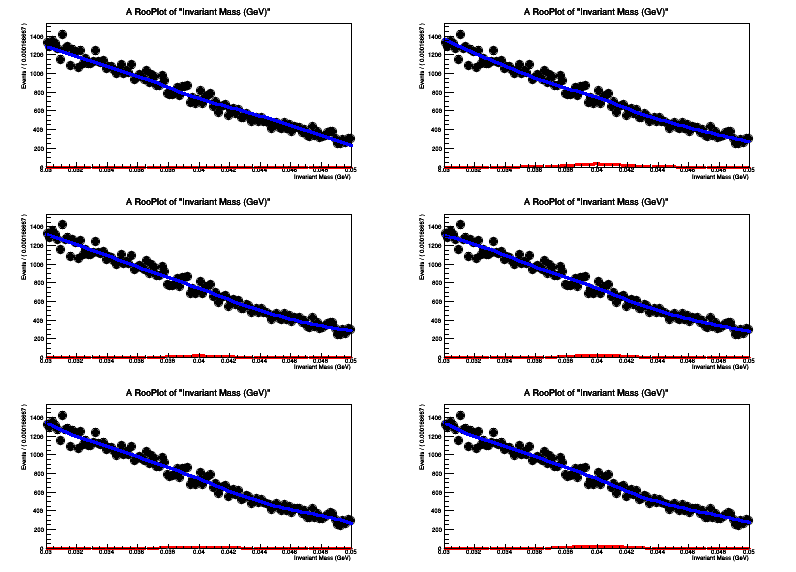

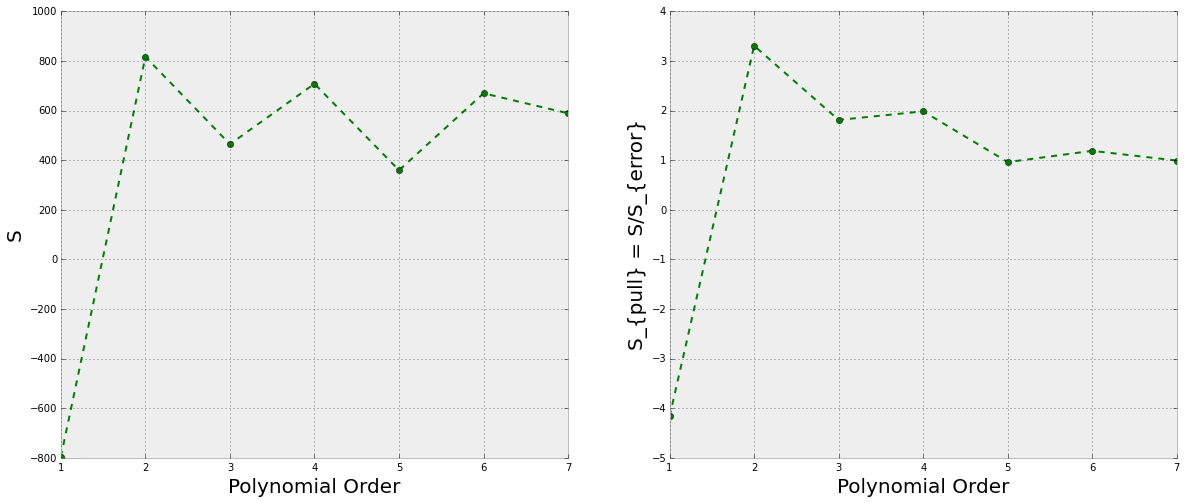

In [58]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

# Create a data histogram that is compatible with RooFit
min_val = 0.03
max_val = 0.05
ap_mass_val = min_val + (max_val - min_val)/2
print "Setting A' mass hypothesis to: " + str(ap_mass_val)
invariant_mass.setRange("test_range", min_val, max_val)
ap_mass_mean.setVal(ap_mass_val)
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)


canvas.Clear()
canvas.Divide(2,3)

s = []
s_error = []
poly_values = []

index = 1

for model in comp_models :
    
    # Plot the results
    invariant_mass.setRange(min_val, max_val)
    plot = invariant_mass.frame()
    
    # Fit the window to the background model
    result = model.fitTo(histogram_data,
                         r.RooFit.SumCoefRange("test_range"),
                         r.RooFit.Extended(r.kTRUE),
                         r.RooFit.Range("test_range"),
                         r.RooFit.Save())
    
    histogram_data.plotOn(plot)
    model.plotOn(plot,
                 r.RooFit.Range("test_range"), 
                 r.RooFit.NormRange("test_range"))
    model.plotOn(plot, 
                 r.RooFit.Range("test_range"),
                 r.RooFit.NormRange("test_range"), 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))
    
    canvas.cd(index)
    plot.Draw()
    
    # Calculate the chi^2
    #print "chi2/dof: " + str(plot.chiSquare())
    
    params = model.getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    poly_values.append(index)
    
    index += 1
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

s_pull = np.divide(np.array(s), np.array(s_error))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))

ax0.plot(poly_values, s, 'g--o')
ax0.set_xlabel("Polynomial Order", fontsize=20)
ax0.set_ylabel("S", fontsize=20)
ax1.plot(poly_values, s_pull, 'g--o')
ax1.set_xlabel("Polynomial Order", fontsize=20)
ax1.set_ylabel("S_{pull} = S/S_{error}", fontsize=20)
        
canvas

Bkg yield mean: 90411.2344792
Bkg yield error: 299.512150495
Bkg yield fit error mean: 300.684775255
Bkg yield fit error error: 0.497876353987
Pull mean: 300.683619167
Pull sigma: 0.498177849858


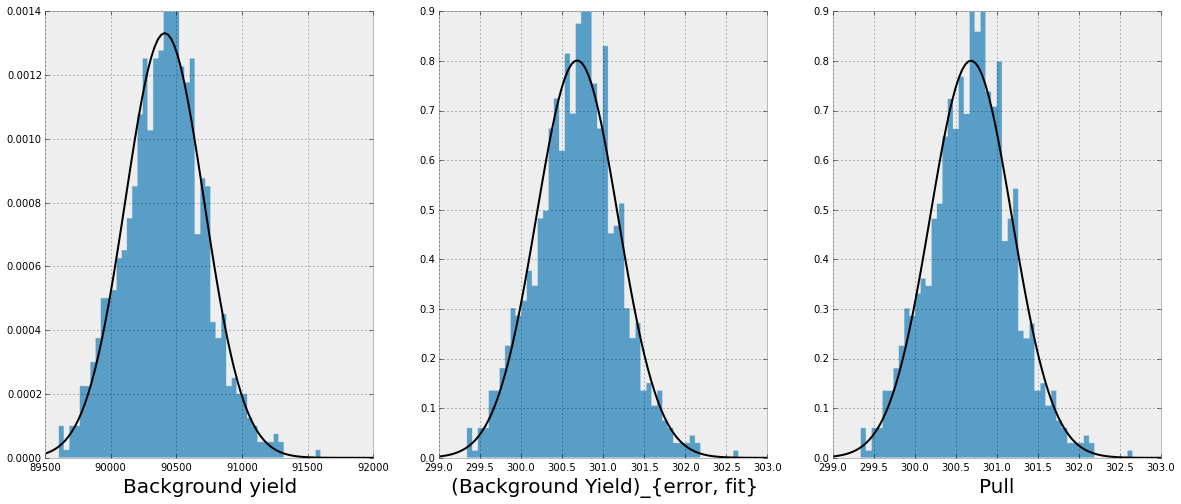

In [34]:

# Create a data histogram that is compatible with RooFit
min_val = 0.03
max_val = 0.05
invariant_mass.setRange("test_range", min_val, max_val)
ap_mass_mean.setVal(ap_mass_val)

# Path to the ROOT file that will be used to obtain the toy invariant mass distributions used to evaluate the fitter
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass3/1pt05_mc/tridents/all/invariant_mass_toys_pt167mev.root"

root_file = root_open(file_path)

histos = list(root_file.objects(r.TH1))

n_bkg = []
n_bkg_error = []

for hist_count in range(0, 1000) : 
    
    histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", 
                                   r.RooArgList(invariant_mass), histos[hist_count])

    
    nll = bkg_comp_models[4].createNLL(histogram_data, 
                          r.RooFit.Extended(r.kTRUE), 
                          r.RooFit.Range("test_range"),
                          r.RooFit.SumCoefRange("test_range"))
    
    m = r.RooMinuit(nll)
    
    m.migrad()
    
    result = m.save()
    
    params = bkg_comp_models[4].getVariables()
    n_bkg.append(params.find("nbkg").getVal())
    n_bkg_error.append(params.find("nbkg").getError())
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

    
nbkg_array = np.array(n_bkg)


nbkg_error_array = np.array(n_bkg_error)

pull = np.divide(nbkg_array, nbkg_error_array)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 8))

mu, std = norm.fit(nbkg_array)
print "Bkg yield mean: " + str(mu)
print "Bkg yield error: " + str(std)
ax0.hist(nbkg_array, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax0.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax0.plot(x, p, 'k', linewidth=2)
ax0.set_xlabel("Background yield", fontsize=20)

mu, std = norm.fit(nbkg_error_array)
print "Bkg yield fit error mean: " + str(mu)
print "Bkg yield fit error error: " + str(std)
ax1.hist(nbkg_error_array, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'k', linewidth=2)
ax1.set_xlabel("(Background Yield)_{error, fit}", fontsize=20)

mu, std = norm.fit(pull)
print "Pull mean: " + str(mu)
print "Pull sigma: " + str(std)
ax2.hist(pull, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2)
ax2.set_xlabel("Pull", fontsize=20);

Signal yield mean: 152.899350546
Signal yield error: 384.896826816
Signal yield fit error mean: 360.455569525
Signal yield fit error error: 3.90636343908
Pull mean: 0.435505002188
Pull sigma: 1.07240621364


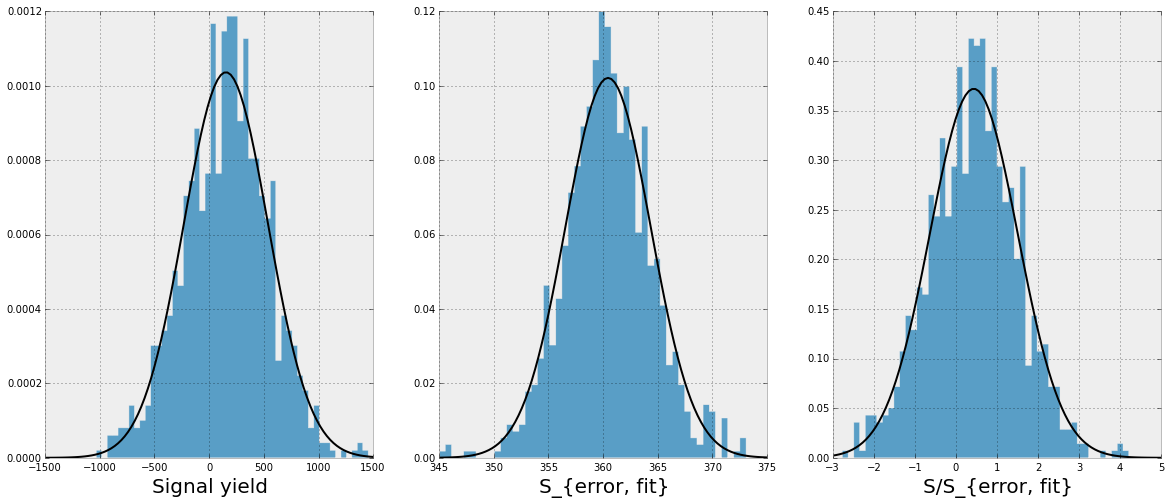

In [37]:
# Create a data histogram that is compatible with RooFit
min_val = 0.03
max_val = 0.05
invariant_mass.setRange("test_range", min_val, max_val)
ap_mass_mean.setVal(ap_mass_val)

# Path to the ROOT file that will be used to obtain the toy invariant mass distributions used to evaluate the fitter
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass3/1pt05_mc/tridents/all/invariant_mass_toys_pt167mev.root"

root_file = root_open(file_path)

histos = list(root_file.objects(r.TH1))

n_bkg = []
n_bkg_error = []

for hist_count in range(0, 1000):
    
    histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", 
                                   r.RooArgList(invariant_mass), histos[hist_count])

    
    nll = comp_models[4].createNLL(histogram_data, 
                          r.RooFit.Extended(r.kTRUE), 
                          r.RooFit.Range("test_range"),
                          r.RooFit.SumCoefRange("test_range"))
    
    m = r.RooMinuit(nll)
    
    m.migrad()
    
    result = m.save()
    
    params = comp_models[4].getVariables()
    n_bkg.append(params.find("nsig").getVal())
    n_bkg_error.append(params.find("nsig").getError())
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

    
nbkg_array = np.array(n_bkg)
nbkg_error_array = np.array(n_bkg_error)
pull = np.divide(nbkg_array, nbkg_error_array)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 8))

mu, std = norm.fit(nbkg_array)
print "Signal yield mean: " + str(mu)
print "Signal yield error: " + str(std)
ax0.hist(nbkg_array, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax0.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax0.plot(x, p, 'k', linewidth=2)
ax0.set_xlabel("Signal yield", fontsize=20)

mu, std = norm.fit(nbkg_error_array)
print "Signal yield fit error mean: " + str(mu)
print "Signal yield fit error error: " + str(std)
ax1.hist(nbkg_error_array, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, 'k', linewidth=2)
ax1.set_xlabel("S_{error, fit}", fontsize=20)

mu, std = norm.fit(pull)
print "Pull mean: " + str(mu)
print "Pull sigma: " + str(std)
ax2.hist(pull, bins=50, histtype="stepfilled", alpha=0.8, normed=True)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'k', linewidth=2)
ax2.set_xlabel("S/S_{error, fit}", fontsize=20);

# Fitting Using the Model

In [7]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

# Create a data histogram that is compatible with RooFit
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

canvas.Clear()

mass_window_size = 0.020
mass_window_step = 0.0005
mass_window_start = 0.03

invariant_mass.setRange(0.005, 0.1)

plot = invariant_mass.frame()
histogram_data.plotOn(plot)

s = []
s_error = []
mass = []


while mass_window_start <= 0.06 - mass_window_size : 
    
    #print "Fitting in window [ " + str(mass_window_start) + ", " + str(mass_window_start + mass_window_size) + " ]"
    ap_mass = mass_window_start + mass_window_size/2
    
    invariant_mass.setRange(mass_window_start, mass_window_start + mass_window_size)
    invariant_mass.setRange("A' mass = " + str(ap_mass),
                            mass_window_start,
                            mass_window_start + mass_window_size)
    #plot = invariant_mass.frame()
    #histogram_data.plotOn(plot)
    
    ap_mass_mean.setVal(ap_mass)
    #print "Setting A' mass hypothesis to " + str(ap_mass_mean.getVal()) + " GeV"
    mass.append(ap_mass)
    
    # Fit the window to the background model
    result = comp_models[4].fitTo(histogram_data,
                         #r.RooFit.SumCoefRange("A' mass = " + str(ap_mass)),
                         r.RooFit.Extended(r.kTRUE),
                         r.RooFit.Range("A' mass = " + str(ap_mass)),
                         r.RooFit.Save())
    
    comp_models[4].plotOn(plot,
                 r.RooFit.Range("A' mass = " + str(ap_mass)), 
                 r.RooFit.NormRange("A' mass = " + str(ap_mass)))
    
    params = comp_models[4].getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    mass_window_start += mass_window_step
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
    #    print "Resetting value of " + str(a_var.GetName())
    #    print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
    #    print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
        
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

invariant_mass.setRange(0.005, 0.1)

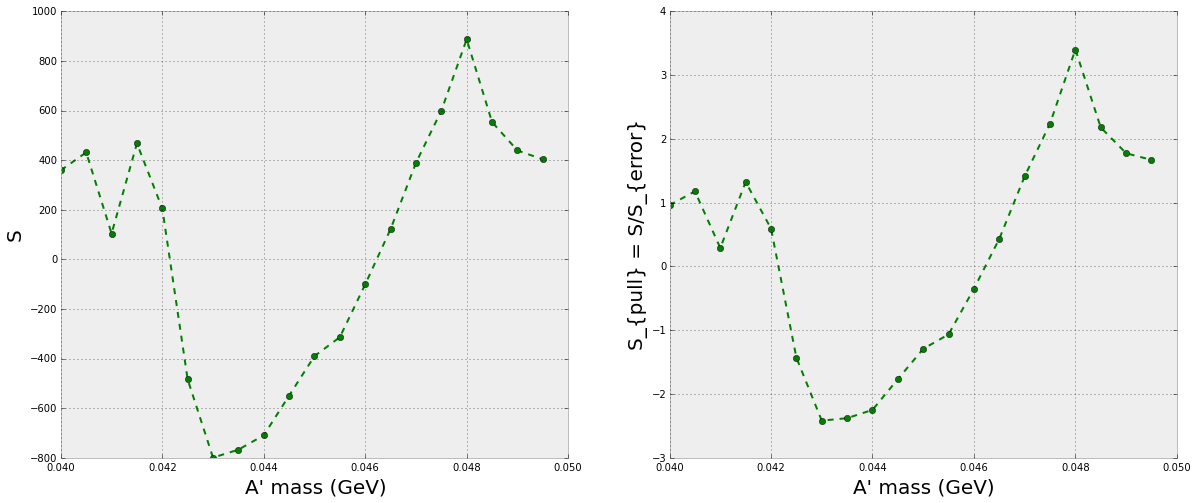

In [8]:
s_pull = np.divide(np.array(s), np.array(s_error))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))

ax0.plot(mass, s, 'g--o')
ax0.set_xlabel("A' mass (GeV)", fontsize=20)
ax0.set_ylabel("S", fontsize=20)
ax1.plot(mass, s_pull, 'g--o')
ax1.set_xlabel("A' mass (GeV)", fontsize=20)
ax1.set_ylabel("S_{pull} = S/S_{error}", fontsize=20)